### Hypothesis: CA1 performs Bayesian inference on the stimulus to infer current place in position x morph space

Posterior probability of the true stimulus, $S$ , given the animals observation, $\hat{S}$ , is $P(S|\hat{S}) \propto P(\hat{S}|S)P(S)$ (Bayes Rule),
where $P(\hat{S}|S)$ is the likelihood of an observation given the stimulus (aka noisy estimate of the stimulus), and $P(S)$ is the prior over the stimuli.


All we're going to do is change the prior and see what happens to the $MAP$ estimate

In [1]:
import numpy as np
import scipy as sp
import scipy.ndimage.filters as filters
from scipy.interpolate import interp1d as spline
from astropy.convolution import convolve


from matplotlib import pyplot as plt

%matplotlib inline


In [2]:
# preliminaries - make general purpose functions
gaussian = lambda mu,sigma,x: np.exp(-(mu-x)**2/sigma**2)
def gaussian_dens(mu,sigma,x):
    v = gaussian(mu,sigma,x)
    return v/v.sum()

def mult_and_norm(dens1,dens2):
    post = dens1*dens2
    return post/post.sum()



The results look like the mouse perceives the stimulus on the log scale, so I am going to do a correction of the sampled morph values to this space to show that this is a better match to the data

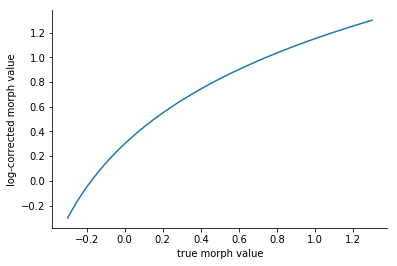

In [3]:
# demonstrating that the log scale of the stimulu is not a linear function of the morph value
theta = np.linspace(-.3,1.3,num=160) # possible morph values
f1,f2 = 3,8 # actual frequencies the mouse sees

theta_corrected = np.log(f1*(1-theta) + f2*(theta)) # log of the linear combinations of the stimuli
# scale this so it's back in the range of the morph values without distortion
theta_corrected = (theta_corrected-np.amin(theta_corrected))/(np.amax(theta_corrected)-np.amin(theta_corrected)) *1.6 - .3 
# print(theta_corrected[0],theta_corrected[-1])
theta_corrected[0],theta_corrected[-1]=-.3,1.3 # hard code the edges to correct float errors

# splines for going between the two spaces
morph_2_logstim = spline(theta,theta_corrected)
logstim_2_morph = spline(theta_corrected,theta)

f,ax = plt.subplots()
ax.plot(theta,theta_corrected)
ax.set_xlabel('true morph value')
ax.set_ylabel('log-corrected morph value')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)





In [4]:

def run_posterior_inference(p_theta):
    '''function runs probabilistic inference and makes a few helpful plots
    Inputs: p_theta - the stimulus prior in log-space sampled at the values of previously defined theta
    Returns: figure and axes handles'''
    
    
    
    ### RUN SOME DEMOS OF WHAT THE INFERENCE PROCESS LOOKS LIKE AT DIFFERENT STIMULUS VALUES
    
    # likelihood - zero centered gaussian with fixed variance in log space
    p_s_theta = gaussian_dens(0,.2,theta)

    # posterior - multiply likelihood and posterior and normalize to be a valid distribution
    p_theta_s = mult_and_norm(p_s_theta,p_theta)

    f_post_demo,ax_post_demo = plt.subplots(1,5,figsize=[15,3])
    ax_post_demo[0].plot(theta,p_theta,label='prior')
    ax_post_demo[0].plot(theta,p_s_theta,label='likelihood',alpha=.4)
    ax_post_demo[0].plot(theta,p_theta_s,label='posterior')
    
    ax_post_demo[0].spines['right'].set_visible(False)
    ax_post_demo[0].spines['top'].set_visible(False)
    ax_post_demo[0].set_ylim([0,.05])
    # repeat above for a few other stimulus values
    for i,s in enumerate([.25,.5,.75,1]):
        # likelihood 
        p_s_theta = gaussian_dens(s,.2,theta)

        # posterior 
        p_theta_s = mult_and_norm(p_s_theta,p_theta)


        ax_post_demo[i+1].plot(theta,p_theta,label='prior')
        ax_post_demo[i+1].plot(theta,p_s_theta,label='likelihood',alpha=.4)
        ax_post_demo[i+1].plot(theta,p_theta_s,label='posterior')
        ax_post_demo[i+1].spines['right'].set_visible(False)
        ax_post_demo[i+1].spines['top'].set_visible(False)
        ax_post_demo[i+1].set_ylim([0,.05])

    ax_post_demo[-1].legend()
    ### CALCULATE POSTERIOR AT RANGE OF STIMULUS VALUES AND PLOT
        
    f_post_dens,ax_post_dens = plt.subplots()
    ax_post_dens.spines['right'].set_visible(False)
    ax_post_dens.spines['top'].set_visible(False)
    theta_hat=[] # keep track of MAP estimate
    p_shat = [] # posterior at current value of stimulus
    for i,s in enumerate(theta): # sample log-spaced values
        p_s_theta = gaussian_dens(s,.2,theta) # likelihood
        p_theta_s = mult_and_norm(p_s_theta,p_theta) # posterior
        
        
        ax_post_dens.plot(logstim_2_morph(theta),p_theta_s,color=plt.cm.cool(1-i/100.)) # convert back from logspace
        theta_hat.append(theta[np.argmax(p_theta_s)]) # MAP estimate
        p_shat.append((p_s_theta*p_theta).sum())

    ax_post_dens.set_ylabel('P')
    ax_post_dens.set_xlabel('morph value')
    ax_post_dens.set_title('Posterior density for different stimulus values')

    ## PLOT MAP ESTIMATE
    f_MAP,ax_MAP = plt.subplots(1,2,figsize=[10,3])
    f_MAP.subplots_adjust(wspace=.5)
    ax_MAP[0].spines['right'].set_visible(False)
    ax_MAP[0].spines['top'].set_visible(False)
    ax_MAP[0].scatter(logstim_2_morph(theta),logstim_2_morph(np.array(theta_hat)))
    ax_MAP[0].set_ylim([1.3,-.3])
    ax_MAP[0].set_ylabel('MAP morph estimate')
    ax_MAP[0].set_xlabel('true morph value')
    
    ax_MAP[1].spines['right'].set_visible(False)
    ax_MAP[1].spines['top'].set_visible(False)
    ax_MAP[1].scatter(logstim_2_morph(theta),np.array(theta_hat))
    ax_MAP[1].set_ylim([1.3,-.3])
    ax_MAP[1].set_ylabel('log-scale MAP morph estimate')
    ax_MAP[1].set_xlabel('true morph value')
    
    return np.array(p_shat),(f_post_demo,ax_post_demo),(f_post_dens,ax_post_dens),(f_MAP,ax_MAP)


def convert_prior_to_log(prior):
    '''convert a prior distribution in stimulus space to logspace for proper sampling
    Input: prior - arbitrary distribution assumed to be sampled in the range of values of theta variable
    Returns: log_dens - log space density for use with run_posterior_inference
             log_sampling_spline - log space cummulative distribution spline for sampling with kWTA_network_model (defined below)'''
    
    # normalize to ensure prior is a proper distribution
    prior/=prior.sum()
    # go to cummulative distribution so that conversion maintains density
    cum_prior = np.cumsum(prior)
    cum_prior[0],cum_prior[-1] = 0,1 # correct for float errors
    cum_spline = spline(theta,cum_prior) # fit a linear interpolation spline so that we can arbitrarily sample
    log_cum_spline = spline(theta_corrected,cum_prior)
    log_cum = log_cum_spline(theta) # sample cummulative distribution in log space
    log_sampling_spline = spline(cum_prior,theta_corrected)  # create transposed spline for sampling values according to their probability
    
    f,ax = plt.subplots(1,2)
    
    
    for a in range(2):
        ax[a].spines['right'].set_visible(False)
        ax[a].spines['top'].set_visible(False)
        
    ax[0].plot(theta,cum_prior,label='morph space')
    ax[0].plot(theta_corrected,cum_prior,label='log space')
    ax[0].legend()
    ax[0].set_ylabel('Cum Prob')
    ax[0].set_xlabel('morph')
    
    ax[1].plot(theta,prior)
    #convert cumulative density back to density
    log_dens = log_cum[1:]-log_cum[:-1]
    log_dens[:10]= log_dens[10] # stretching at the end of the spline causes artifacts so we're just clamping those values 
    log_dens = np.append(log_dens,log_dens[-1])
    log_dens /=log_dens.sum()
    ax[1].plot(theta,log_dens)
    ax[1].set_ylabel('Prob')
    ax[1].set_xlabel('morph')
    ax[1].set_ylim([0,.05])
    
    return log_dens, log_sampling_spline


## Rare Morph Prior Bayesian Inference

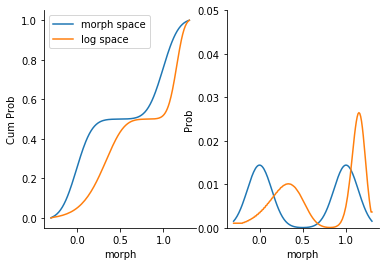

In [5]:
### BUILD PRIOR

# setup Rare Morph prior in logspace as a Gaussian mixture with means at 0 and 1
rare_prior = np.zeros([160,])
rare_prior = gaussian(0,.2,theta)+gaussian(1,.2,theta)
rare_prior /= rare_prior.sum()

rare_log_dens, rare_lcs = convert_prior_to_log(rare_prior)




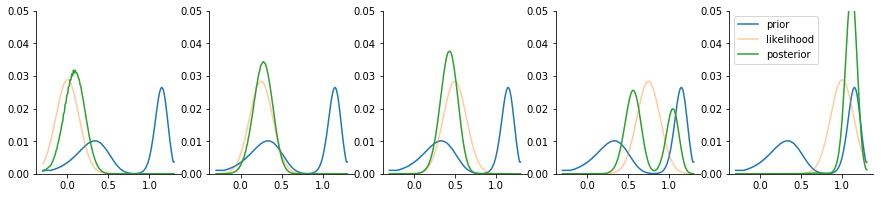

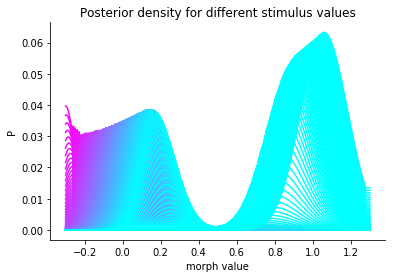

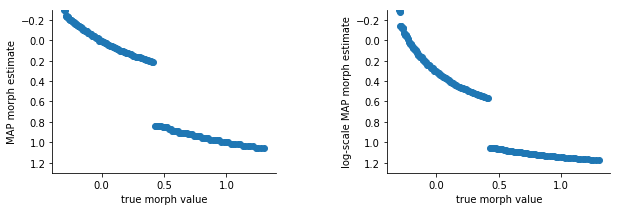

In [6]:
# RUN INFERENCE

rare_p_shat, (f_post_demo,ax_post_demo),(f_post_dens,ax_post_dens),(f_MAP,ax_MAP) = run_posterior_inference(rare_log_dens)

## Frequent Morph Prior Bayesian Inference
Prior is uniform in the true morph space (not uniform in log space)

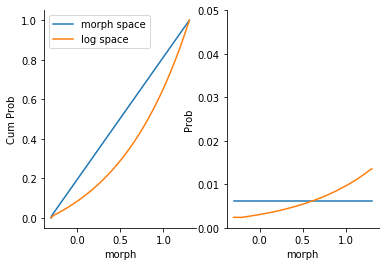

In [7]:
# setup prior in logspace
fam_prior = np.ones(theta.shape)
fam_prior/=fam_prior.sum()

fam_log_dens, fam_lcs = convert_prior_to_log(fam_prior)


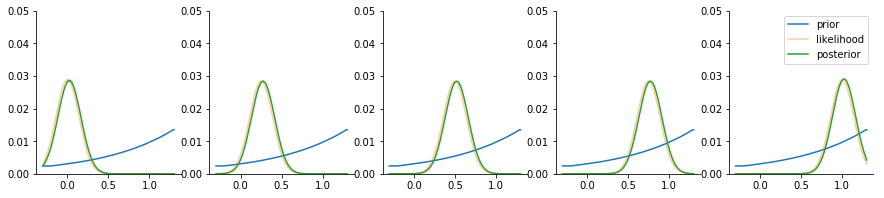

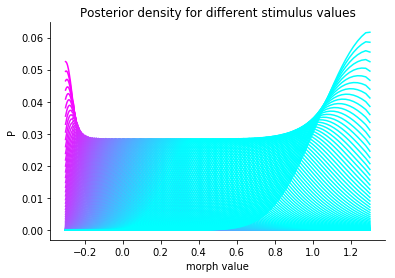

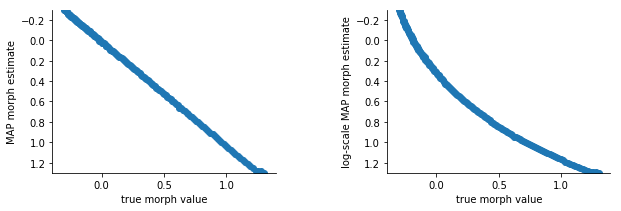

In [8]:

fam_p_shat,(f_post_demo,ax_post_demo),(f_post_dens,ax_post_dens),(f_MAP,ax_MAP) = run_posterior_inference(fam_log_dens)
    

# Approximating Bayesian inference in a network model with Hebbian learning and winner take all dynamics

Motivation: Consider a single cell that performs Hebbian learning on its inputs. If the input neurons, $x_i$ , are a basis for the stimulus and the weights are initialized randomly and small, after learning, the weights of the inputs, $w_i$ will reflect the statistics of the inputs. In particular they will approximate the prior distribution for the stimulus. In the following example, we take a single linear point neuron that itself receives input from a set of neurons whose firing rates are radial basis functions for some external stimulus. 

The output of the cell $y$ is just a weighted sum of its inputs: $y=\sum_i{w_i x_i} = \alpha w^{T}x$ where $\alpha$ is a constant

Weights are updated according a Hebbian learning rule with forgetting $\Delta w_i = \eta x_i y_i - \tau $ 

We will also add that weights cannot be negative or go beyond some max value $w_i := min \{ max \{w_i + \Delta w_i,0 \},w_{max}\}$

-$\eta$ is the learning rate

-$\tau$ is a forgetting rate

In [9]:
### EXAMPLE SINGLE CELL HEBBIAN LEARNING

d_def= {'stim noise': .05, # constant for sampling from standard Gaussian noise
    'nInputs': 1000, # number of input neurons
    'nSamples': 1000, # number of training samples
    'alpha':None,
    'eta': .2, # learning rate, results are somewhat sensitive to this value
    'sigma': .1, # width of radial basis functions
    'act noise':1, # noise to apply to output
    'dW noise': .1, # constant to apply to weight update noise 
     'tau': .001 # forgetting rate
       }


def single_cell_model(log_cumprior_spline,d):
    '''
    implement hebbian learning for a single cell with inputs that are RBFs for some stimulus
    inputs: log_cumprior_spline - numpy univariate spline for sampling from the cumulative prior
            d - dictionary of parameters
    returns: w - weights of learned model
            yy - activity of cell
    '''
    
    ### INITIALIZATIONS
    THETA = np.linspace(-.3,1.3,num=d['nInputs']) 
    if d['alpha'] is None:
        d['alpha']=1/d['nInputs']
        
        
    w = np.random.rand(d['nInputs']) # uniformly distributed random weights
    
    #working in log space
    samples = log_cumprior_spline(np.linspace(0,1,num=d['nSamples'])) # generate samples that tile the prior
    samples = np.random.permutation(samples) # randomly permute them
    
    
    ### LEARNING
    
    for i,s in enumerate(samples.tolist()):
        # generate samples from inputs
        x =gaussian(THETA,d['sigma'],s+d['stim noise']*np.random.randn(1)) + d['stim noise']*np.random.randn(THETA.shape[0])
        y=np.maximum(d['alpha']*np.dot(w,x) + d['act noise']*np.random.randn(1),0) # rectified activation of cell
        dw = d['eta']*x*y - d['tau'] + d['dW noise']*np.random.randn(w.shape[0])
        w+=dw 
        w=np.maximum(np.minimum(w,d['Wmax']),0) # rectify and clamp range of weights
        

    ### SAMPLE FROM LEARNED MODEL
    morph_theta = np.linspace(-.1,1.1,num=1000) # morph values to sample at
    test_theta = morph_2_logstim(morph_theta) # convert morph_theta to log space
    
    yy = np.zeros(test_theta.shape) # output 
    for i,s in enumerate(test_theta.tolist()):
        # inputs
        x =gaussian(THETA,d['sigma'],s+d['stim noise']*np.random.randn(1)) + d['stim noise']*np.random.randn(THETA.shape[0])
        
        yy[i]=np.maximum(d['alpha']*np.dot(w,x) + d['act noise']*np.random.randn(1),0) # rectified activation of cell
    
    return w,yy,morph_theta,test_theta,samples



    
    

Text(0.5, 1.0, 'Frequent morph prior')

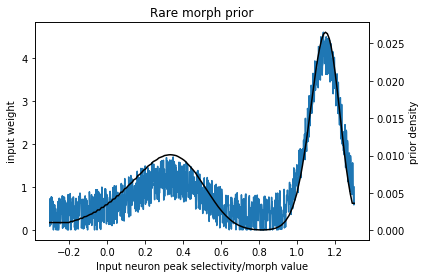

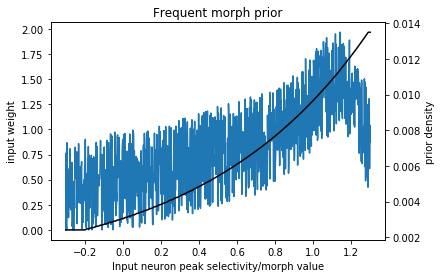

In [10]:
d_singlecell = {'stim noise': .00, # constant for sampling from standard Gaussian noise
    'nInputs': 1000, # number of input neurons
    'nSamples':1000, # num training samples
    'alpha':None,
    'eta': .1, # learning rate, results are somewhat sensitive to this value
    'sigma': .08, # width of radial basis functions
    'act noise':0.0, # noise to apply to output
    'dW noise': 0.0, # constant to apply to weight update noise 
    'tau': .0002, # forgetting rate
    'Wmax':100 }

# rare morph prior
w,y,morph_theta,test_theta,samples = single_cell_model(rare_lcs,d_singlecell)

f,ax = plt.subplots()

ax.plot(np.linspace(-.3,1.3,num=w.shape[0]),w)
ax.set_ylabel('input weight')
ax_dense = ax.twinx()
ax_dense.plot(theta,rare_log_dens,color='black',label='Prior Density')
ax_dense.set_ylabel('prior density')
ax.set_xlabel('Input neuron peak selectivity/morph value')
ax.set_title("Rare morph prior")

# frequent morph prior
w,y,morph_theta,test_theta,samples = single_cell_model(fam_lcs,d_singlecell)

f,ax = plt.subplots()

ax.plot(np.linspace(-.3,1.3,num=w.shape[0]),w)
ax.set_ylabel('input weight')
ax_dense = ax.twinx()
ax_dense.plot(theta,fam_log_dens,color='black',label='Prior Density')
ax_dense.set_ylabel('prior density')
ax.set_xlabel('Input neuron peak selectivity/morph value')
ax.set_title("Frequent morph prior")




This is pretty cool, but the resulting output of this cell is not actually particularly useful quantity for computing the posterior. (It would be something the $P(\hat{S})$ marginalized over all stimuli). If instead, we had neurons that could compute basis functions for the prior, then the population could be used to read out a probability distribution. 

One way to induce to get neurons to represent a basis for the prior rather than the prior itself would be to have cells compete to represent different aspects of the stimulus. One simple way to have cells compete is with Winner-Take-All dynamics. In this case, all of the computations for cell activation are the same, except that only $K$ neurons get to update their weights. The idea here is that these neurons reach threshold first and then inhibit their neighbors.

My hypothesis is that this will be a good model for the data and that simulating such a model will largely recapitulate our results

# K-WTA Network Model




In [11]:
# design input cells - gaussian tuning for different stimulus values
nInputs = 1000
THETA = np.linspace(-.3,1.3,num=nInputs)

eta = .2 # results are somewhat sensitive to this learning rate
tau = .01
sigma = .1

def kwta_network_model(log_cumprior_spline, n_neurons=100, wta_k = .4):
    

    W = np.random.rand(nInputs,n_neurons)
    k = int(n_neurons*wta_k)
    
    
    #working in log space
    samples = log_cumprior_spline(np.linspace(0,1,num=1000))
    eta_vec = eta*samples[::-1]
    samples = np.random.permutation(samples)
    for i,s in enumerate(samples.tolist()):
        prob_input =gaussian(THETA,sigma,s+.05*np.random.randn(1)) + .05*np.random.randn(THETA.shape[0])
        act = np.matmul(W.T,prob_input)
        Y = np.zeros(act.shape)
        sort = np.argsort(act)

        Y[sort[-1:-k-1:-1]]=1/nInputs*act[sort[-1:-k-1:-1]] +np.random.randn(k)#- act[sort[-k-1]].mean()
        Y = np.maximum(Y,0)
        dw = eta*prob_input[:,np.newaxis]*(Y[np.newaxis,:]) + .1*np.random.randn(W.shape[0],W.shape[1])- tau#*W
        W+=dw 
        #W/=.001*np.linalg.norm(W,1,axis=0)[np.newaxis,:]
        W=np.minimum(W,10)
        W = np.maximum(W,0)

    

    morph_theta = np.linspace(0,1,num=1000)
    test_theta = morph_2_logstim(morph_theta)
    YY = np.zeros([test_theta.shape[0],n_neurons])
    for i,s in enumerate(test_theta.tolist()):
        
        prob_input =gaussian(THETA,sigma,s+.05*np.random.randn(1)) + .05*np.random.randn(THETA.shape[0])

        act = np.matmul(W.T,prob_input)
        sort = np.argsort(act)
        
        YY[i,sort[-1:-k-1:-1]]=1/nInputs*act[sort[-1:-k-1:-1]] + np.random.randn(k)#-.1*act[sort[-k-1]].mean()
        
        YY[i,:] = np.maximum(YY[i,:],0)

    centroid0, centroid1 = YY[morph_theta<.1,:].mean(axis=0),YY[morph_theta>.9,:].mean(axis=0)
    centroid0/=np.linalg.norm(centroid0.ravel(),ord=2)
    centroid1/=np.linalg.norm(centroid1.ravel(),ord=2)
#     print(centroid0.shape,centroid1.shape,YY.shape)
    lar = np.log(np.matmul(YY,centroid0[:,np.newaxis])+ 1E-5)-np.log(np.matmul(YY,centroid1[:,np.newaxis])+ 1E-5)
    
    return W,YY,lar



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


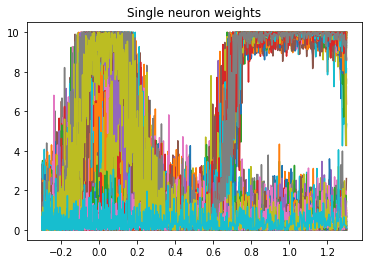

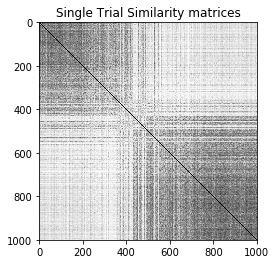

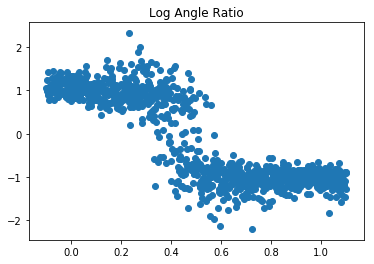

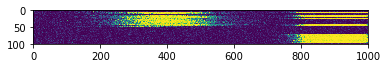

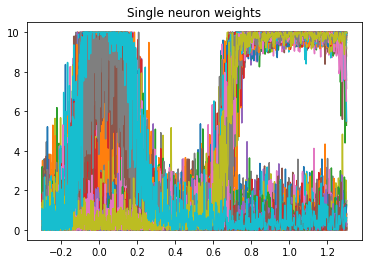

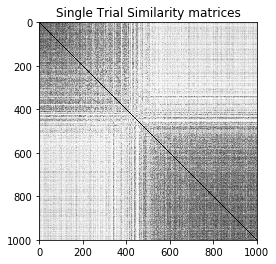

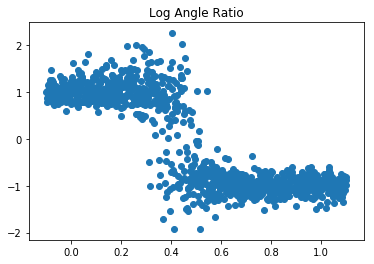

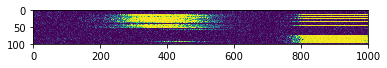

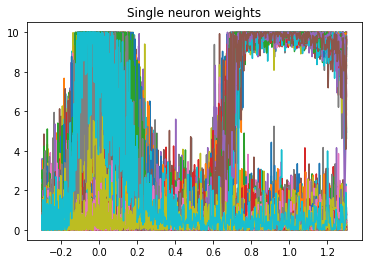

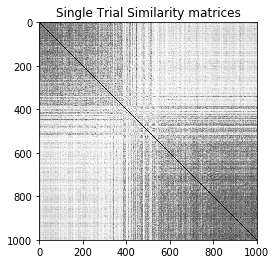

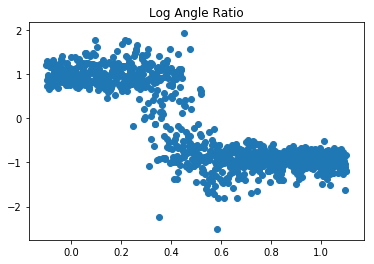

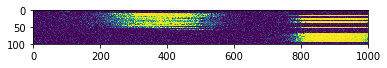

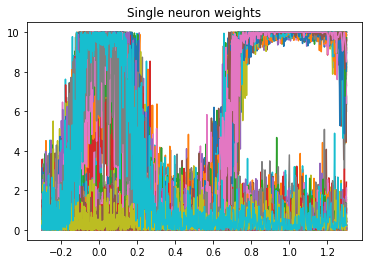

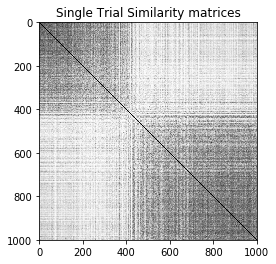

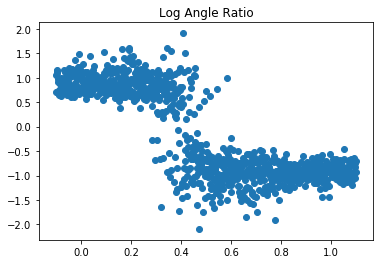

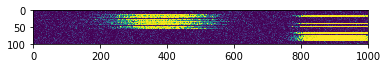

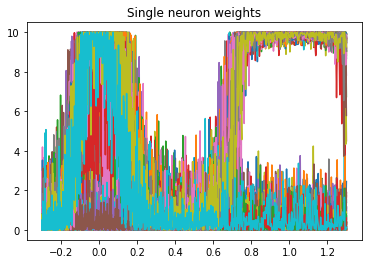

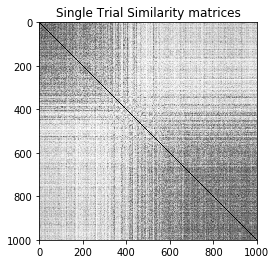

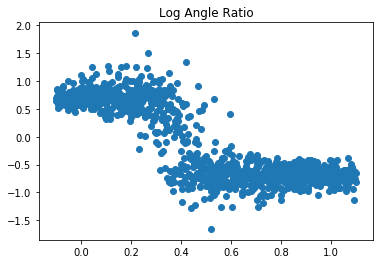

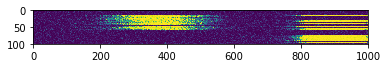

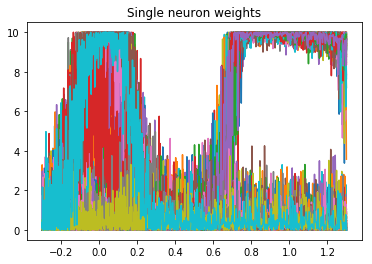

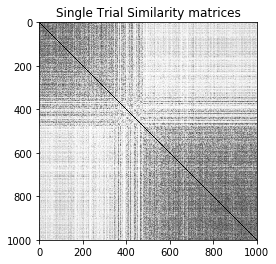

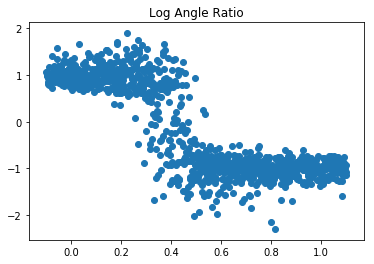

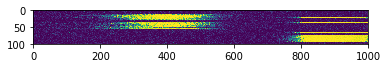

In [264]:
SS_rare,LAR_rare = [],[]
for i in range(30):
    print(i)
#     W_rare,YY_rare,lar_rare= kwta_network_model(spline(cum_rare_prior,theta_corrected),wta_k=.4,n_neurons=100)
    W_rare,YY_rare,lar_rare= kwta_network_model(rare_lcs,wta_k=.4,n_neurons=100)
    
    YY_ = YY_rare/np.linalg.norm(YY_rare+1E-5,2,axis=1)[:,np.newaxis]
    S = np.matmul(YY_,YY_.T)

    SS_rare.append(S)
    LAR_rare.append(lar_rare)
    
    if i <6:
        f,ax = plt.subplots()
        trsh=ax.plot(logstim_2_morph(THETA),W_rare)
        ax.set_title('Single neuron weights')

        
        f,ax = plt.subplots()
        ax.imshow(S,cmap='Greys')
        ax.set_title('Single Trial Similarity matrices')

        f,ax = plt.subplots()
        ax.scatter(np.linspace(-.1,1.1,num=1000),lar_rare)
        ax.set_title('Log Angle Ratio')

        f,ax = plt.subplots()
        # ax.imshow(W_rare.T)
        weight_sort = np.argsort(np.argmax(W_rare,axis=0))
        ax.imshow(W_rare[:,weight_sort].T) #,vmax=4)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


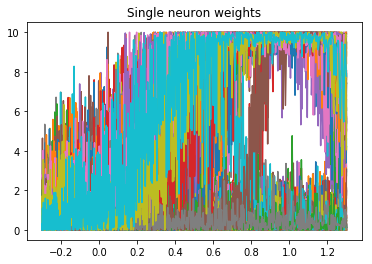

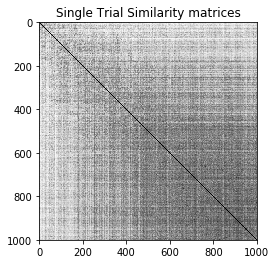

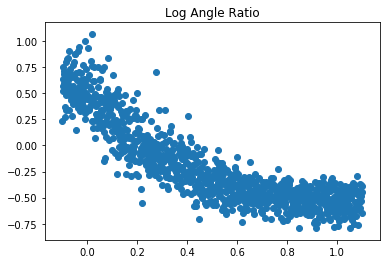

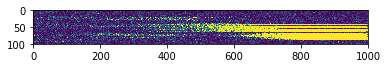

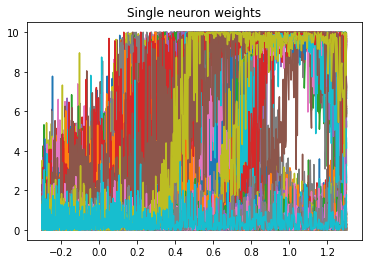

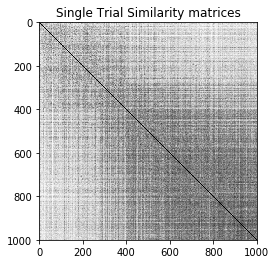

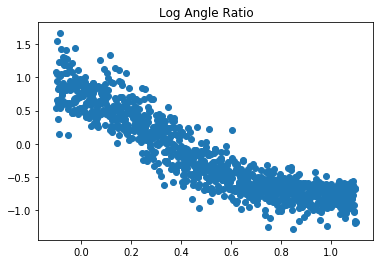

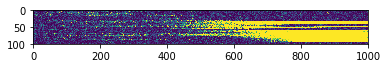

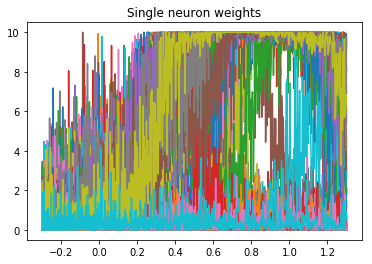

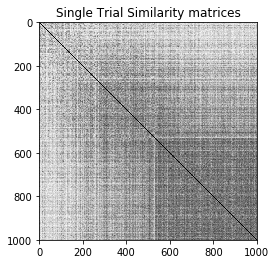

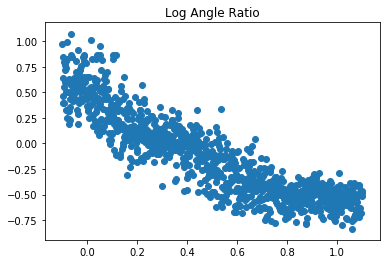

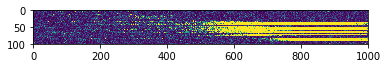

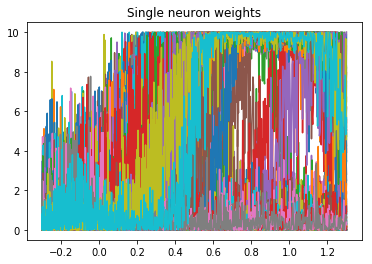

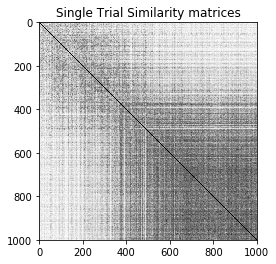

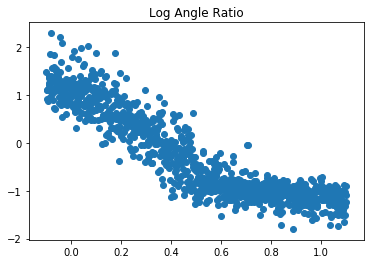

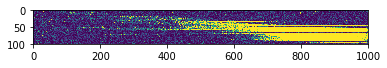

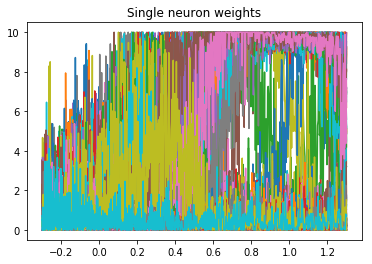

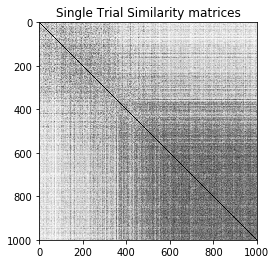

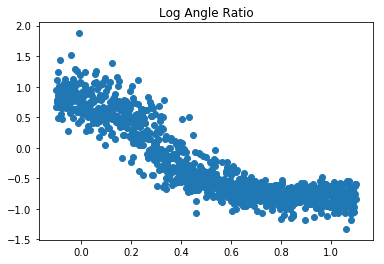

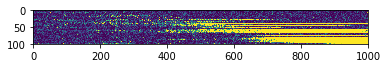

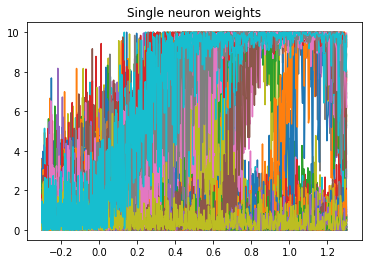

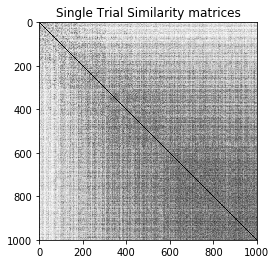

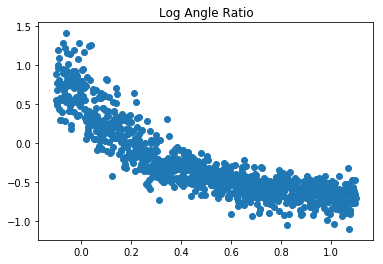

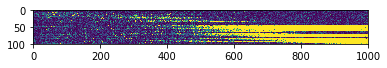

In [265]:
flat_prior_spline = spline(np.linspace(0,1,num=theta_corrected.shape[0]),theta_corrected)
SS_fam,LAR_fam=[],[]
# flat_prior_spline = spline(cum_fam_prior,theta_corrected)
for i in range(30):
    print(i)
    W_fam,YY_fam,lar_fam= kwta_network_model(fam_lcs,wta_k=.4,n_neurons=100)
    YY_ = YY_fam/np.linalg.norm(YY_fam+1E-5,2,axis=1)[:,np.newaxis]
    S = np.matmul(YY_,YY_.T)
    
    SS_fam.append(S)
    LAR_fam.append(lar_fam)
    
    
    if i<6:
        f,ax = plt.subplots()
        trsh=ax.plot(logstim_2_morph(THETA),W_fam)
        ax.set_title('Single neuron weights')
        f,ax = plt.subplots()
        ax.imshow(S,cmap='Greys')
        ax.set_title('Single Trial Similarity matrices')


        f,ax = plt.subplots()
        ax.scatter(np.linspace(-.1,1.1,num=1000),lar_fam)
        ax.set_title('Log Angle Ratio')

        f,ax = plt.subplots()
        weight_sort = np.argsort(np.argmax(W_fam,axis=0))
        ax.imshow(W_fam[:,weight_sort].T,vmax=4)

In [266]:
SS_rare_mu = np.array(SS_rare).mean(axis=0)
SS_fam_mu = np.array(SS_fam).mean(axis=0)

In [267]:
print(np.amin(SS_rare_mu),np.amin(SS_fam_mu))

0.11257933136618208 0.1711040459214501


In [268]:
SS_dif = SS_rare_mu-SS_fam_mu

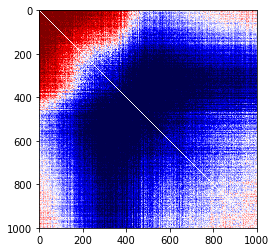

In [269]:
f,ax = plt.subplots()
ax.imshow(SS_dif,vmin=-.2,vmax=.2,cmap='seismic')

In [270]:
print(THETA[0],THETA[-1])
# bin_edges = np.linspace(-.3,1.3,num=6)
bin_edges = np.array([-.3,.125,.375,.625,.85,1.3])

SS_dif_mu = np.zeros([5,5])



for row in range(bin_edges.shape[0]-1):
    row_inds = (THETA>bin_edges[row]) & (THETA<=bin_edges[row+1])
    for col in range(bin_edges.shape[0]-1):
        col_inds = (THETA>bin_edges[col]) & (THETA<=bin_edges[col+1])
        vals = SS_dif[row_inds[:,np.newaxis]*col_inds[np.newaxis,:]]
        
        SS_dif_mu[row,col]=vals.mean()
print(bin_edges)

-0.3 1.3
[-0.3    0.125  0.375  0.625  0.85   1.3  ]


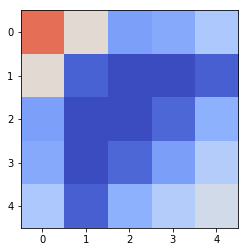

In [271]:
f,ax = plt.subplots()
ax.imshow(SS_dif_mu,vmin=-.2,vmax=.2,cmap='coolwarm')

(49,)


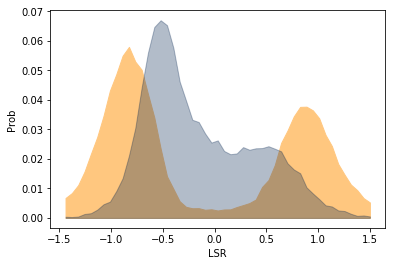

In [272]:
bins = np.linspace(-1.5,1.5)
hist_rare,edges = np.histogram(np.array(LAR_rare).ravel(),bins=bins)
print(hist_rare.shape)
hist_rare =hist_rare/hist_rare.sum()
f,ax = plt.subplots()
ax.fill_between(bins[1:],hist_rare,color=plt.cm.copper(1.))


hist_fam,edges = np.histogram(np.array(LAR_fam).ravel(),bins=bins)
hist_fam = hist_fam/hist_fam.sum()
ax.fill_between(bins[1:],hist_fam,color=plt.cm.cividis(0.),alpha=.3)
ax.set_xlabel('LSR')
ax.set_ylabel('Prob')
f.savefig("./LSR_hist.png")